# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [49]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

In [50]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (4-10 hours) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

- There will most likely be a class imbalance since the majority of people tend to pay their credit card bills. 
- In this problem, false negatives are more important than false positives. Ideally, our model should minimize false negatives. 
- It looks like all features are numeric but they are not scaled.

In [51]:
df = pd.read_csv('UCI_Credit_Card.csv')
X = df.drop(columns=["default.payment.next.month"])
y = df["default.payment.next.month"]
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
) 

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [53]:
X_train.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,14964.174292,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,...,46955.185083,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958
std,8660.479272,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,...,68841.868958,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7467.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.000000,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000
50%,14975.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,20038.000000,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000
75%,22460.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,59970.250000,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


- This table gives us descriptive statistics of each feature; specifically it gives us the 5 number summary along with std, count, and mean. 

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         24000 non-null  int64  
 1   LIMIT_BAL  24000 non-null  float64
 2   SEX        24000 non-null  int64  
 3   EDUCATION  24000 non-null  int64  
 4   MARRIAGE   24000 non-null  int64  
 5   AGE        24000 non-null  int64  
 6   PAY_0      24000 non-null  int64  
 7   PAY_2      24000 non-null  int64  
 8   PAY_3      24000 non-null  int64  
 9   PAY_4      24000 non-null  int64  
 10  PAY_5      24000 non-null  int64  
 11  PAY_6      24000 non-null  int64  
 12  BILL_AMT1  24000 non-null  float64
 13  BILL_AMT2  24000 non-null  float64
 14  BILL_AMT3  24000 non-null  float64
 15  BILL_AMT4  24000 non-null  float64
 16  BILL_AMT5  24000 non-null  float64
 17  BILL_AMT6  24000 non-null  float64
 18  PAY_AMT1   24000 non-null  float64
 19  PAY_AMT2   24000 non-null  float64
 20  PA

- This tells us the data type and count of non-null data points for each feature. 

<br><br>

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'SEX'}>,
        <AxesSubplot:title={'center':'EDUCATION'}>,
        <AxesSubplot:title={'center':'MARRIAGE'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'PAY_0'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [<AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>,
        <AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>],
  

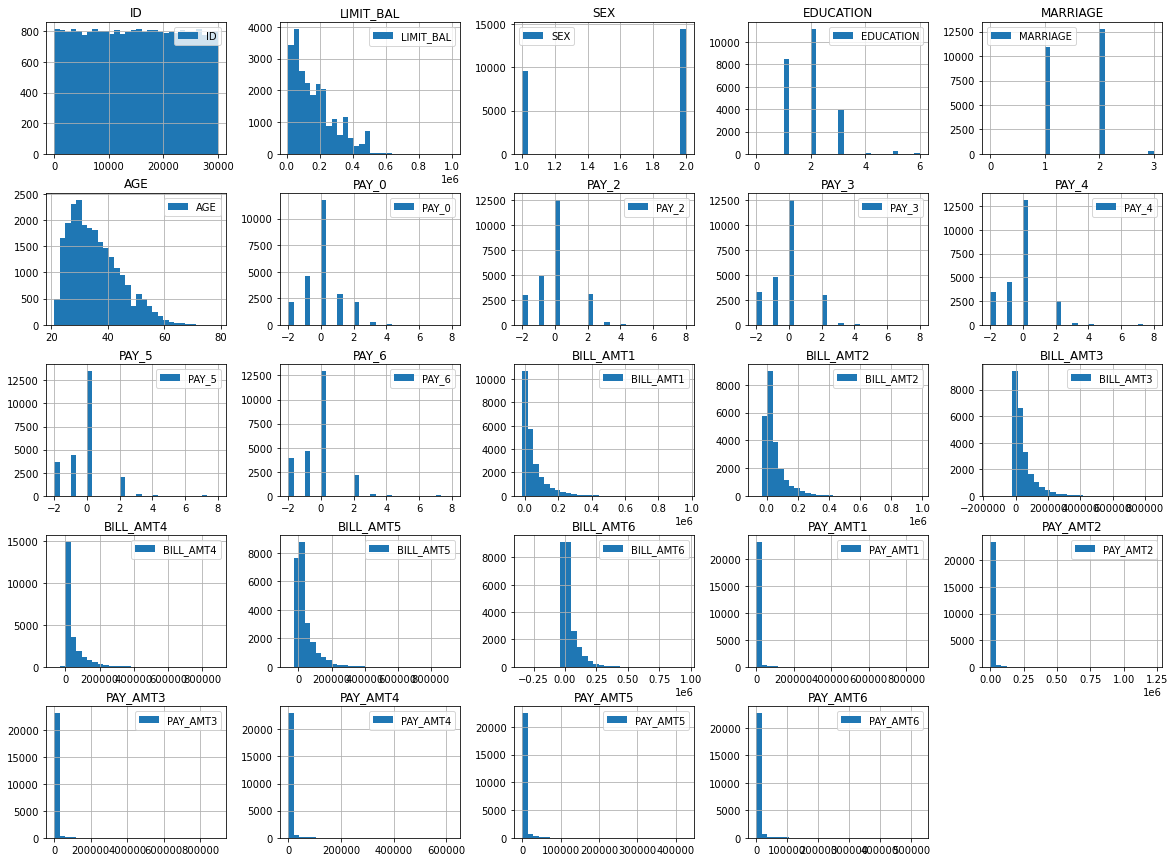

In [55]:
numeric_columns_df = X_train.select_dtypes(include='number')
numeric_columns_df.hist(bins=30, figsize=(20, 15), legend=True)

- Histogram of all numeric features in the train set to see their distribution. 

<AxesSubplot:>

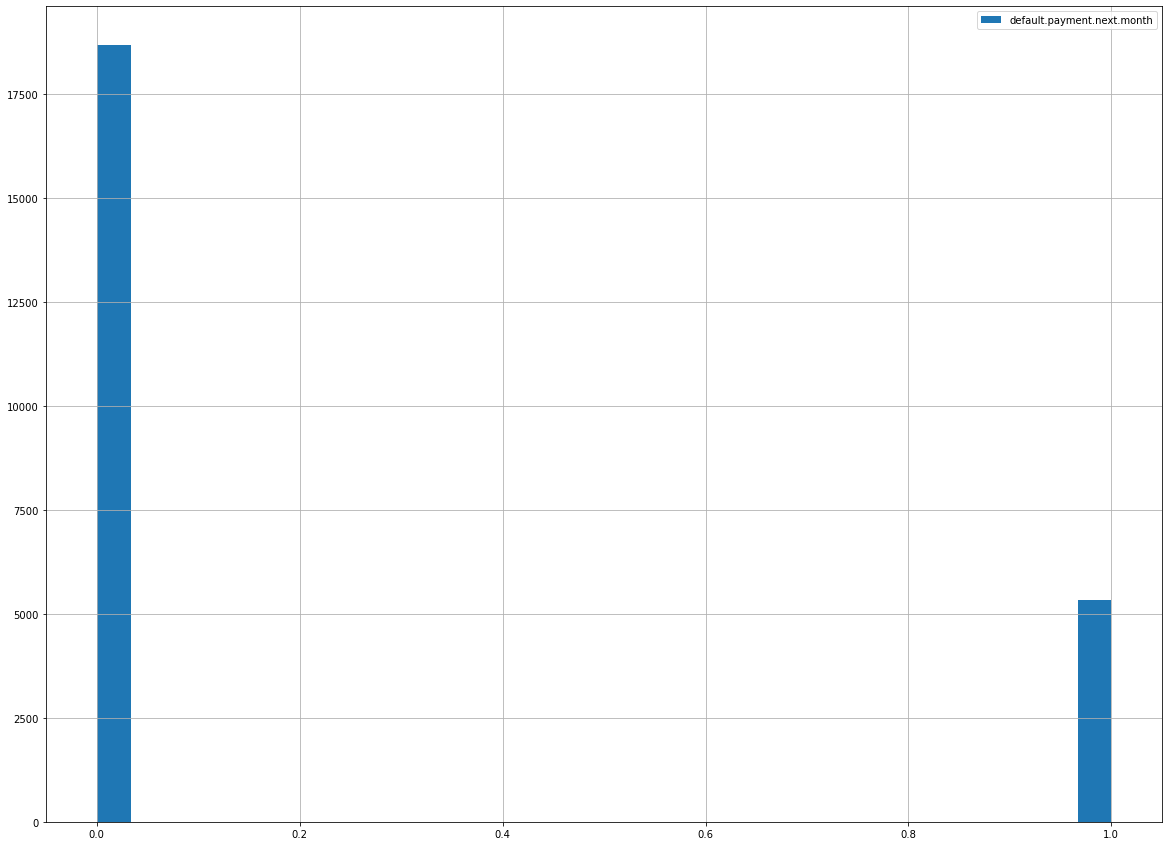

In [56]:
y_train.hist(bins=30, figsize=(20, 15), legend=True)

- This histogram of y_train shows the class imbalance. Much more people path their credit card bills than default. 

**Summary**
- The range of values for some of the features are much greater than others (LIMIT_BAL, BILL_AMT0 to BILL_AMT6, PAY_AMT0 to PAY_AMT6)
- There is class imbalance 
- ID feature can be removed
- All features are numeric
- There are no NULL or Nan values
- Most examples are from educated individuals
- Most examples are from women

**Metrics**
- accuracy
- recall
- 

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [57]:
numeric_feats = [
    "LIMIT_BAL",
    "AGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_2",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
]  # apply scaling
passthrough_feats = ["EDUCATION"]  # do not apply any transformation
drop_feats = ["ID"]  # do not include these features
categorical_feats = ["MARRIAGE", "SEX"]

In [58]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    ("passthrough", passthrough_feats),  # no transformations on the binary features
    ("drop", drop_feats),  # drop the drop features
)

In [59]:
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_2', 'PAY_5', 'PAY_6', 'BILL_AMT1',
                                  'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['MARRIAGE', 'SEX']),
                                ('passthrough', 'passthrough', ['EDUCATION']),
                                ('drop', 'drop', ['ID'])])

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [60]:
results = {}
scoring_metric = ["accuracy", "recall",]

dummy = make_pipeline(ct, DummyClassifier())
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
Dummy,0.055 (+/- 0.009),0.021 (+/- 0.007),0.778 (+/- 0.000),0.778 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [61]:
pipe_lr = make_pipeline(ct, LogisticRegression())
results["Logistic Regression"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

C:\Users\kieranadams\miniconda3\envs\cpsc330\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kieranadams\miniconda3\envs\cpsc330\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
Dummy,0.055 (+/- 0.009),0.021 (+/- 0.007),0.778 (+/- 0.000),0.778 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.356 (+/- 0.065),0.017 (+/- 0.006),0.810 (+/- 0.005),0.810 (+/- 0.001),0.235 (+/- 0.019),0.236 (+/- 0.009)


In [62]:
from sklearn.model_selection import GridSearchCV

pipe_lr = make_pipeline(ct, LogisticRegression())

param_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

In [63]:
grid_search.fit(X_train, y_train) # all the work is done here

C:\Users\kieranadams\miniconda3\envs\cpsc330\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_2',
                                                                          'PAY_5',
                                                                          'PAY_6',
                                                                        

In [64]:
grid_search.best_score_

0.80975

In [65]:
grid_search.best_params_

{'logisticregression__C': 1.0}

In [66]:
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,4,5,6
mean_test_score,0.80975,0.80975,0.80975,0.809667,0.808667,0.801167
std_test_score,0.004614,0.004556,0.004556,0.004682,0.004573,0.004285
param_logisticregression__C,1.0,10,100,0.1,0.01,0.001
mean_fit_time,0.565399,0.621601,0.603802,0.564599,0.327795,0.318396


**Summary**
- The best score is 0.80975 for C = 1.0
- The logistic regression model produces better accuracy and most importantly recall. 

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pipe_svc = make_pipeline(
    ct, SVC()
)
results["SVC"] = mean_std_cross_val_scores(
    pipe_svc, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pipe_rf = make_pipeline(
    ct, RandomForestClassifier(random_state=123, n_jobs=-1, n_estimators=3)
)
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
Dummy,0.055 (+/- 0.009),0.021 (+/- 0.007),0.778 (+/- 0.000),0.778 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.356 (+/- 0.065),0.017 (+/- 0.006),0.810 (+/- 0.005),0.810 (+/- 0.001),0.235 (+/- 0.019),0.236 (+/- 0.009)
Decision tree,0.612 (+/- 0.111),0.016 (+/- 0.003),0.723 (+/- 0.006),0.999 (+/- 0.000),0.406 (+/- 0.009),0.997 (+/- 0.001)
SVC,32.577 (+/- 2.960),6.181 (+/- 0.152),0.819 (+/- 0.005),0.824 (+/- 0.002),0.341 (+/- 0.013),0.355 (+/- 0.005)
Random forests,1.388 (+/- 1.889),0.090 (+/- 0.037),0.767 (+/- 0.008),0.954 (+/- 0.001),0.381 (+/- 0.020),0.867 (+/- 0.004)


<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [68]:
from sklearn.model_selection import GridSearchCV

pipe_rf = make_pipeline(
    ct, RandomForestClassifier(random_state=123, n_jobs=-1)
)
param_grid = {
    "randomforestclassifier__n_estimators": [1, 10, 100],
    "randomforestclassifier__max_depth": [1, 3, 5, 7, 9, 11, 13],
}

grid_search = GridSearchCV(
    pipe_rf, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

grid_search.fit(X_train, y_train) # all the work is done here


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_2',
                                                                          'PAY_5',
                                                                          'PAY_6',
                                                                        

In [69]:
grid_search.best_score_

0.8204166666666666

In [70]:
grid_search.best_params_

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__n_estimators': 100}

In [71]:
pipe_rf = make_pipeline(ct,  RandomForestClassifier(random_state=123, n_jobs=-1, max_depth=7, n_estimators=100))
pipe_rf.fit(
    X_train, y_train
)  # Retrain a model with optimized hyperparameters on the combined training and validation set

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE', 'PAY_0',
                                                   'PAY_2', 'PAY_3', 'PAY_2',
                                                   'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6']),
                                                 ('onehotencoder',
              

**Summary**
- The best model based on the previous question was the random forest classifier. It had high accuracy and high recall. 
- The best params were max_depth = 7 and n_estimators = 100

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [72]:
import eli5

ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names()
    .tolist()
)

feature_names = (
    numeric_feats + ohe_feature_names + passthrough_feats
)

eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

C:\Users\kieranadams\miniconda3\envs\cpsc330\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight,Feature
0.3344 ± 0.4074,PAY_0
0.1237 ± 0.3588,PAY_2
0.1088 ± 0.3328,PAY_2
0.0709 ± 0.2192,PAY_3
0.0526 ± 0.1732,PAY_5
0.0315 ± 0.1218,PAY_6
0.0301 ± 0.0536,PAY_AMT1
0.0296 ± 0.1261,PAY_6
0.0247 ± 0.0475,LIMIT_BAL
0.0229 ± 0.0351,PAY_AMT3


<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [73]:
pipe_rf.score(X_test, y_test)  # Final evaluation on the test data

0.823

- This is a good result. Our validation and train accuracy is almost the same. Therefore, I do not think the model is biased. 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

In [74]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

recall_score(y_test, pipe_rf.predict(X_test))

0.37806748466257667

- Final Score: 0.823
- Recall = 0.37

- Recall value is still very small. A different model than RandomForestClassifier might be better
- Feature engineering could improve performance
- More hyperparam tuning could improve performance/interpretability|

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 